In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

import biff
from pygadgetreader import *
from octopus import profiles
from octopus import orbit_cm
from astropy import constants
from astropy import units as u

from octopus import profiles

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
print G_c

4.51835939627e-39 kpc3 / (s2 solMass)


In [3]:
font = {'size':16, 'family':'serif'}
plt.matplotlib.rc('font', **font)

## To-Do:

1. Check Mass of MW+LMC 
2. Check scatter plot with potential colorbar
3. Check 1.5 factor in potential and sqrt(1\pi)/1.5 in acceleration
4. Locate the LMC in the HEx potential

In [4]:
MWLMCi = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'pos', 'dm')
MWLMCi_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'mass', 'dm')
MWLMCi_pot = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'pot', 'dm')

MWLMCf = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pos', 'dm')
MWLMCf_vel = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'vel', 'dm')
MWLMCf_pid = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pid', 'dm')
MWLMCf_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'mass', 'dm')
MWLMCf_pot = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pot', 'dm')

Returning DM    Positions
Returning DM    Mass
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Mass
Returning DM    Potential


In [5]:
xmw_cm = 3.14213492468
ymw_cm = 33.1085245965
zmw_cm = -10.5106429199

In [6]:
MWLMCf[:,0] = MWLMCf[:,0] - xmw_cm
MWLMCf[:,1] = MWLMCf[:,1] - ymw_cm
MWLMCf[:,2] = MWLMCf[:,2] - zmw_cm

In [7]:
trunc2 = np.where(np.sqrt((MWLMCi[:,0])**2.0 + (MWLMCi[:,1])**2.0 + (MWLMCi[:,2])**2.0)<500)[0]
trunc3 = np.where(np.sqrt((MWLMCf[:,0])**2.0 + (MWLMCf[:,1])**2.0 + (MWLMCf[:,2])**2.0)<500)[0]

In [8]:
MWLMCi_t = MWLMCi[trunc2]
MWLMCi_mass_t = MWLMCi_mass[trunc2]
MWLMCi_pot_t = MWLMCi_pot[trunc2]

MWLMCf_t = MWLMCf[trunc3]
MWLMCf_mass_t = MWLMCf_mass[trunc3]
MWLMCf_pot_t = MWLMCf_pot[trunc3]

In [9]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [10]:
# Function to write the coefficients.
def writting_coeff(name, S, T):
    f = open(name, 'w')
    f.write("# S    T \n")
    S1d = np.reshape(S, (np.size(S),1))
    T1d = np.reshape(T, (np.size(T),1))
    for i in range(len(S1d)):
        f.write("%f %f \n"%(S1d[i][0], T1d[i][0]))
    f.close

# MW + LMC initial state

In [11]:
r_MWLMCi_t = np.sqrt(MWLMCi_t[:,0]**2.0 + MWLMCi_t[:,1]**2.0 + MWLMCi_t[:,2]**2.0)

In [12]:
SMWLMCi1, TMWLMCi1, nlmsMWLMCi1 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 1, 0)

MWLMCbfe_pot = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi1, TMWLMCi1, 1, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi1, TMWLMCi1, 1, 0, 1.55E12, 40.85)

In [13]:
SMWLMCi2, TMWLMCi2, nlmsMWLMCi2 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 10, 0)

MWLMCbfe_pot2 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi2, TMWLMCi2, 10, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho2 = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi2, TMWLMCi2, 10, 0, 1.55E12, 40.85)

In [14]:
SMWLMCi3, TMWLMCi3, nlmsMWLMCi3 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 20, 0)

MWLMCbfe_pot3 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi3, TMWLMCi3, 20, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho3 = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi3, TMWLMCi3, 20, 0, 1.55E12, 40.85)

In [15]:
SMWLMCi4, TMWLMCi4, nlmsMWLMCi4 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 5, 5)


In [16]:
MWLMCbfe_pot4 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi4, TMWLMCi4, 5, 5, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho4 = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi4, TMWLMCi4, 20, 5, 1.55E12, 40.85)

In [27]:
#SMWLMCi5, TMWLMCi5, nlmsMWLMCi5 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 10, 10)
MWLMCbfe_pot5 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi5, TMWLMCi5, 10, 10, G_c.value, 1.55E12, 40.85)


In [34]:
#SMWLMCi6, TMWLMCi6, nlmsMWLMCi6 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 20, 20)
MWLMCbfe_pot6 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi6, TMWLMCi6, 20, 20, G_c.value, 1.55E12, 40.85)


In [19]:
x = np.reshape(SMWLMCi4, (np.size(SMWLMCi4),1))
x[20][0]

-0.052412128421399501

In [ ]:
writting_coeff('MWLMC1-n1', SMWLMCi1, TMWLMCi1)
writting_coeff('MWLMC1-n10', SMWLMCi2, TMWLMCi2)
writting_coeff('MWLMC1-n20', SMWLMCi3, TMWLMCi3)
writting_coeff('MWLMC1-n5-l5', SMWLMCi4, TMWLMCi4)
writting_coeff('MWLMC1-n10-l10', SMWLMCi5, TMWLMCi5)
writting_coeff('MWLMC1-n20-l20', SMWLMCi6, TMWLMCi6)

In [20]:
# From Gadget units to physical units in kpc, Msun and s
pot_factor = G_c/43007.1*1E10

In [36]:
potential_nb = np.zeros((len(r_MWLMCi_t), 2))
potential_nb[:,0] = r_MWLMCi_t
potential_nb[:,1] = MWLMCi_pot_t
potential_nb = np.sort(potential_nb, axis=0)


potential1 = np.zeros((len(r_MWLMCi_t), 2))
potential1[:,0] = r_MWLMCi_t
potential1[:,1] = MWLMCbfe_pot
potential1 = np.sort(potential1, axis=0)

potential2 = np.zeros((len(r_MWLMCi_t), 2))
potential2[:,0] = r_MWLMCi_t
potential2[:,1] = MWLMCbfe_pot2
potential2 = np.sort(potential2, axis=0)


potential3 = np.zeros((len(r_MWLMCi_t), 2))
potential3[:,0] = r_MWLMCi_t
potential3[:,1] = MWLMCbfe_pot3
potential3 = np.sort(potential3, axis=0)

potential4 = np.zeros((len(r_MWLMCi_t), 2))
potential4[:,0] = r_MWLMCi_t
potential4[:,1] = MWLMCbfe_pot4
potential4 = np.sort(potential4, axis=0)

potential5 = np.zeros((len(r_MWLMCi_t), 2))
potential5[:,0] = r_MWLMCi_t
potential5[:,1] = MWLMCbfe_pot5
potential5 = np.sort(potential5, axis=0)



potential6 = np.zeros((len(r_MWLMCi_t), 2))
potential6[:,0] = r_MWLMCi_t
potential6[:,1] = MWLMCbfe_pot6
potential6 = np.sort(potential6, axis=0)

In [22]:
bulge_pot_hex = profiles.pot_hernquist(0.7, np.sort(r_MWLMCi_t), 1.4E10)
disk_pot_hex = profiles.pot_mn(0.638, 2.9, np.sort(r_MWLMCi_t), 0, 0, 5.78E10)

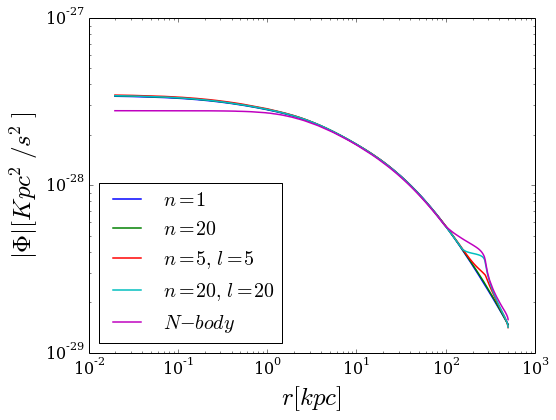

In [68]:
factor = 1.5
plt.figure(figsize=(8,6))
plt.loglog(potential1[:,0], np.abs(potential1[:,1]/factor + bulge_pot_hex + disk_pot_hex), lw=1.5, label='$n=1$')
plt.loglog(potential3[:,0], np.abs(potential3[:,1]/factor + bulge_pot_hex + disk_pot_hex), lw=1.5, label='$n=20$')
plt.loglog(potential4[:,0], np.abs(potential4[:,1]/factor + bulge_pot_hex + disk_pot_hex), lw=1.5, label='$n=5,\ l=5$')
plt.loglog(potential6[:,0], np.abs(potential6[:,1]/factor + bulge_pot_hex + disk_pot_hex), lw=1.5, label='$n=20,\ l=20$')
plt.loglog(potential_nb[:,0], np.abs(potential_nb[:,1]*pot_factor.value), lw=1.5, label='$N-body$')

#plt.xlim(1, 500)

plt.legend(fontsize=20, loc='best')
plt.xlabel(r'$r[kpc]$', fontsize=25)
plt.ylabel(r'$|\Phi|[Kpc^2/s^2]$', fontsize=25)

In [47]:
def potential_residuals(pot_nbody, pot_hex):
    pot_factor = G_c/43007.1*1E10 
    pot_nbody = pot_nbody * pot_factor.value
    # Analytic Disk & Bulge potentials 
    bulge_pot_hex = profiles.pot_hernquist(0.7, np.sort(r_MWLMCi_t), 1.4E10)
    disk_pot_hex = profiles.pot_mn(0.638, 2.9, np.sort(r_MWLMCi_t), 0, 0, 5.78E10)
    pot_hex = pot_hex/factor + bulge_pot_hex + disk_pot_hex
    pot_res = (pot_hex - pot_nbody) / pot_nbody
    return pot_res

In [72]:
pot_res1 = potential_residuals(potential_nb[:,1], potential1[:,1])
pot_res2 = potential_residuals(potential_nb[:,1], potential2[:,1])
pot_res3 = potential_residuals(potential_nb[:,1], potential3[:,1])
pot_res4 = potential_residuals(potential_nb[:,1], potential4[:,1])


pot_res_arg = np.argsort(pot_res1, axis=0)

In [71]:
np.argsort?

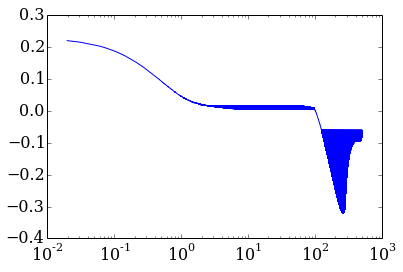

In [74]:
plt.semilogx(potential1[pot_res_arg,0], pot_res1[pot_res_arg], lw=1)
#plt.semilogx(potential2[:,0], pot_res2, lw=1)
#plt.semilogx(potential2[:,0], pot_res3, lw=1)
#plt.semilogx(potential4[:,0], pot_res4, lw=1)
#plt.xlim(1, 500)

In [75]:
MWLMCi_pot1d = np.reshape(MWLMCi_pot_t, (len(MWLMCi_pot_t), 1))

In [80]:
MWLMC1_pot1d = np.zeros(len(MWLMCi_pot_t))
for i in range(len(MWLMCi_pot_t)):
    MWLMC1_pot1d[i] = MWLMCi_pot_t[i]

In [83]:
print MWLMC1_pot1d[:10]

[-15166.10058594 -15315.22460938 -15704.86230469 -15700.06933594
 -15544.35058594 -15426.45800781 -15221.68847656 -15333.07617188
 -15512.36523438 -15100.14160156]


<matplotlib.colorbar.Colorbar instance at 0x7f41ceba09e0>

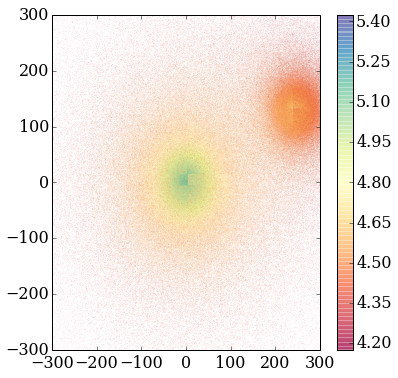

In [82]:
cm = plt.cm.get_cmap('Spectral')
plt.figure(figsize=(6,6))
plt.scatter(MWLMCi_t[:,1], MWLMCi_t[:,2], s=0.1, edgecolors='none', c=np.log10(np.abs(MWLMC1_pot1d)), 
            vmin=min(np.log10(np.abs(MWLMC1_pot1d))),vmax=max(np.log10(np.abs(MWLMC1_pot1d))), cmap=cm, alpha=0.5)
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.colorbar()

In [121]:
pot_res1d = np.reshape(pot_res1, (len(pot_res1), 1))

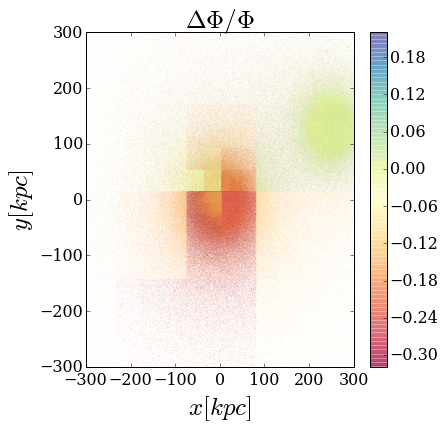

In [122]:
cm = plt.cm.get_cmap('Spectral')
plt.figure(figsize=(6,6))
plt.scatter(MWLMCi_t[:,1], MWLMCi_t[:,2], c=(pot_res1d),
           vmin=min(pot_res1d),vmax=max(pot_res1d), cmap=cm, s=0.1, edgecolors='none', alpha=0.5)
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.colorbar()
plt.xlabel(r'$x[kpc]$', fontsize=25)
plt.ylabel(r'$y[kpc]$', fontsize=25)
plt.title(r'$\Delta \Phi / \Phi$', fontsize=25)

In [126]:
pot_res_cut_h = np.where(np.abs(pot_res1d)>0.05)[0]

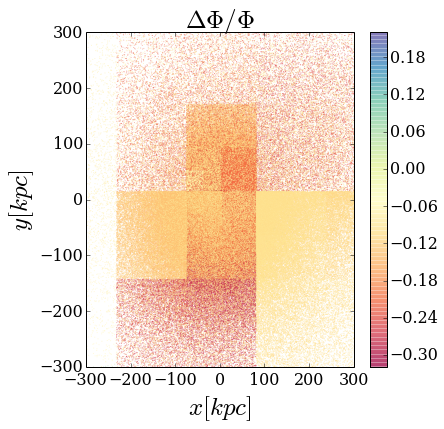

In [128]:
cm = plt.cm.get_cmap('Spectral')
plt.figure(figsize=(6,6))
plt.scatter(MWLMCi_t[pot_res_cut_h,1], MWLMCi_t[pot_res_cut_h,2], c=(pot_res1d[pot_res_cut_h]),
           vmin=min(pot_res1d[pot_res_cut_h]),vmax=max(pot_res1d[pot_res_cut_h]), cmap=cm, s=1, edgecolors='none', alpha=0.5)
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.colorbar()
plt.xlabel(r'$x[kpc]$', fontsize=25)
plt.ylabel(r'$y[kpc]$', fontsize=25)
plt.title(r'$\Delta \Phi / \Phi$', fontsize=25)

# MW + LMC final state

In [133]:
SMWLMCf1, TMWLMCf1, nlmsMWLMCf1 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 1, 0)

MWLMCbfe_pot_f = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf1, TMWLMCf1, 1, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf1, TMWLMCf1, 1, 0, 1.55E12, 40.85)

In [134]:
SMWLMCf2, TMWLMCf2, nlmsMWLMCf2 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 10, 0)

MWLMCbfe_pot_f2 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf2, TMWLMCf2, 10, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f2 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf2, TMWLMCf2, 10, 0, 1.55E12, 40.85)

In [135]:
SMWLMCf3, TMWLMCf3, nlmsMWLMCf3 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 20, 0)

MWLMCbfe_pot_f3 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf3, TMWLMCf3, 20, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f3 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf3, TMWLMCf3, 20, 0, 1.55E12, 40.85)

In [136]:
SMWLMCf4, TMWLMCf4, nlmsMWLMCf4 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 5, 5)

MWLMCbfe_pot_f4 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf4, TMWLMCf4, 5, 5, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f4 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf4, TMWLMCf4, 5, 5, 1.55E12, 40.85)

In [155]:
SMWLMCf5, TMWLMCf5, nlmsMWLMCf5 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 10, 10)

MWLMCbfe_pot_f5 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf5, TMWLMCf5, 10, 10, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f5 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf5, TMWLMCf5, 10, 10, 1.55E12, 40.85)

In [160]:
SMWLMCf6, TMWLMCf6, nlmsMWLMCf6 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 20, 20)

MWLMCbfe_pot_f6 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf6, TMWLMCf6, 20, 20, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f6 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf6, TMWLMCf6, 20, 20, 1.55E12, 40.85)

In [138]:
r_MWLMCf_t = np.sqrt(MWLMCf_t[:,0]**2.0 + MWLMCf_t[:,1]**2.0 + MWLMCf_t[:,2]**2.0)


In [156]:
potentialf_nb = np.zeros((len(r_MWLMCf_t), 2))
potentialf_nb[:,0] = r_MWLMCf_t
potentialf_nb[:,1] = MWLMCf_pot_t
potentialf_nb = np.sort(potentialf_nb, axis=0)


potentialf1 = np.zeros((len(r_MWLMCf_t), 2))
potentialf1[:,0] = r_MWLMCf_t
potentialf1[:,1] = MWLMCbfe_pot_f
potentialf1 = np.sort(potentialf1, axis=0)

potentialf2 = np.zeros((len(r_MWLMCf_t), 2))
potentialf2[:,0] = r_MWLMCf_t
potentialf2[:,1] = MWLMCbfe_pot_f2
potentialf2 = np.sort(potentialf2, axis=0)


potentialf3 = np.zeros((len(r_MWLMCf_t), 2))
potentialf3[:,0] = r_MWLMCf_t
potentialf3[:,1] = MWLMCbfe_pot_f3
potentialf3 = np.sort(potentialf3, axis=0)

potentialf4 = np.zeros((len(r_MWLMCf_t), 2))
potentialf4[:,0] = r_MWLMCf_t
potentialf4[:,1] = MWLMCbfe_pot_f4
potentialf4 = np.sort(potentialf4, axis=0)


potentialf5 = np.zeros((len(r_MWLMCf_t), 2))
potentialf5[:,0] = r_MWLMCf_t
potentialf5[:,1] = MWLMCbfe_pot_f5
potentialf5 = np.sort(potentialf5, axis=0)


In [146]:
bulge_potf_hex = profiles.pot_hernquist(0.7, np.sort(r_MWLMCf_t), 1.4E10)
disk_potf_hex = profiles.pot_mn(0.638, 2.9, np.sort(r_MWLMCf_t), 0, 0, 5.78E10)

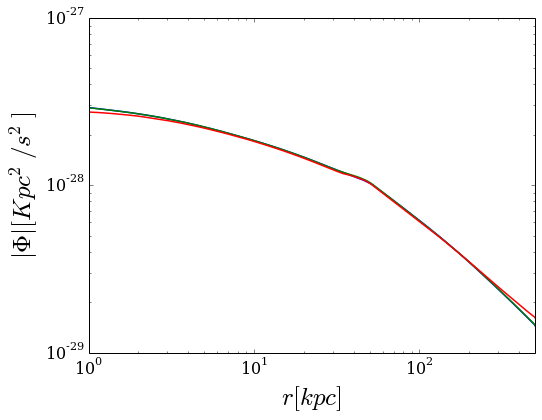

In [157]:
factor = 1.5
plt.figure(figsize=(8,6))
#plt.loglog(potentialf1[:,0], np.abs(potentialf1[:,1]/factor + bulge_potf_hex + disk_potf_hex), lw=1.5)
#plt.loglog(potentialf2[:,0], np.abs(potentialf2[:,1]/factor + bulge_potf_hex + disk_potf_hex), lw=1.5)
#plt.loglog(potentialf3[:,0], np.abs(potentialf3[:,1]/factor + bulge_potf_hex + disk_potf_hex), lw=1.5)
plt.loglog(potentialf4[:,0], np.abs(potentialf4[:,1]/factor + bulge_potf_hex + disk_potf_hex), lw=1.5)
plt.loglog(potentialf5[:,0], np.abs(potentialf5[:,1]/factor + bulge_potf_hex + disk_potf_hex), lw=1.5)
plt.loglog(potentialf_nb[:,0], np.abs(potentialf_nb[:,1]*pot_factor.value), lw=1.5)

plt.xlim(1, 500)

plt.legend(fontsize=15, loc='best')
plt.xlabel(r'$r[kpc]$', fontsize=25)
plt.ylabel(r'$|\Phi|[Kpc^2/s^2]$', fontsize=25)

In [150]:
def potential_residualsf(pot_nbody, pot_hex):
    pot_factor = G_c/43007.1*1E10 
    pot_nbody = pot_nbody * pot_factor.value
    # Analytic Disk & Bulge potentials 
    bulge_pot_hex = profiles.pot_hernquist(0.7, np.sort(r_MWLMCf_t), 1.4E10)
    disk_pot_hex = profiles.pot_mn(0.638, 2.9, np.sort(r_MWLMCf_t), 0, 0, 5.78E10)
    pot_hex = pot_hex/factor + bulge_pot_hex + disk_pot_hex
    pot_res = (pot_hex - pot_nbody) / pot_nbody
    return pot_res

In [158]:
pot_resf1 = potential_residualsf(potentialf_nb[:,1], potentialf1[:,1])
pot_resf2 = potential_residualsf(potentialf_nb[:,1], potentialf2[:,1])
pot_resf3 = potential_residualsf(potentialf_nb[:,1], potentialf3[:,1])
pot_resf4 = potential_residualsf(potentialf_nb[:,1], potentialf4[:,1])
pot_resf5 = potential_residualsf(potentialf_nb[:,1], potentialf5[:,1])

(1, 500)

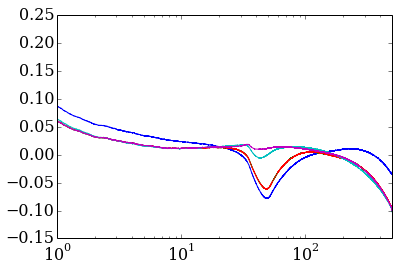

In [159]:
plt.semilogx(potentialf1[:,0], pot_resf1, lw=1)
plt.semilogx(potentialf2[:,0], pot_resf2, lw=1)
plt.semilogx(potentialf3[:,0], pot_resf3, lw=1)
plt.semilogx(potentialf4[:,0], pot_resf4, lw=1)
plt.semilogx(potentialf5[:,0], pot_resf5, lw=1)
plt.xlim(1, 500)

In [164]:
index_min_pot = np.where(potentialf4[:,1] == min(potentialf4[:,1]))[0]
print index_min_pot

[0]


In [163]:
MWLMCf_t[:,0]**2.0 + MWLMCf_t[:,1]**2.0 + MWLMCf_t[:,2]**2.0)


-2.0781320699229696e-29